In [1]:
import numpy as np
from numpy.random import randint
import matplotlib.pylab as plt
import sys,os

import tensorflow as tf
from tensorflow.keras import layers, Model

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9412401566986668679
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7486465818198468804
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4083183977622375147
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7899945370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6312452902868181266
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


## Example of synthetic data 


In [17]:
import matplotlib as mpl


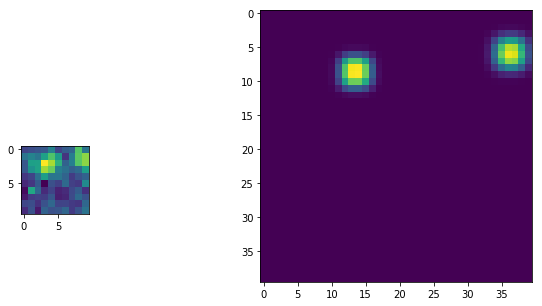

In [23]:
fig = plt.figure(figsize=(14,5))
gs = mpl.gridspec.GridSpec(4, 8 , wspace=0., hspace=0.) # 2x3 grid

ax0 = fig.add_subplot(gs[2,2]) # first full col
ax1 = fig.add_subplot(gs[:,4:]) # first row, second col
ax0.imshow(Ft.mean(axis=-1))
ax1.imshow(Ot4)

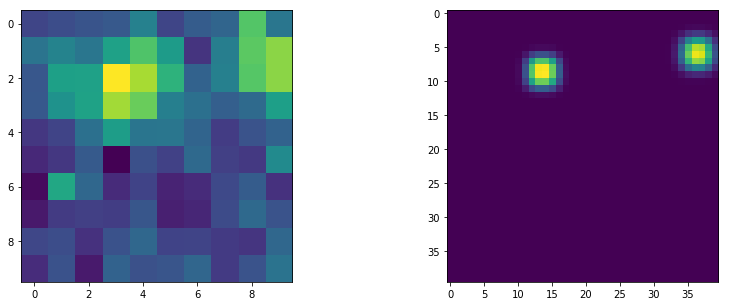

In [3]:
home = "/export/home1/users/bssn/serna"
datadir = home+"/SyntheticData/syndat/"
#os.listdir(datadir)
i = randint(0,900)
Ft = np.load(datadir+"d"+str(i).zfill(4)+".npy")
Ot4 = np.load(datadir+"o4_"+str(i).zfill(4)+".npy")
fig,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].imshow(Ft.mean(axis=-1))
ax[1].imshow(Ot4)
width,height,T = Ft.shape  

In [4]:
Ot4.max()

0.9483595543633605

# Obtaining training data set

In [45]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

def readdata(nframes,i0=0,n=800,magn=2,repeat = 4):

    X = np.zeros((n*repeat,width,height,nframes))
    Y = np.zeros((n*repeat,width*magn,height*magn))
    j = 0
    for i in range(i0,i0+n):
        xt = np.load(datadir+"d"+str(i).zfill(4)+".npy")
        yt = np.load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy") 
        xt = xt/xt.max()
        ymax = max(1,yt.max())
        # This is to avoid 0s in pictures without blinking spots, 
        # but it may give us problems, most likely
        for ir in range(repeat):
            start,end = get_random_time_segment(nframes,T)
            X[j,:,:,:] = xt[:,:,start:end]
            Y[j,:,:] = yt/ymax
            j = j+1
    X = np.reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
    #Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))
    return(X,Y)

In [46]:
nframes = 100
X,Y = readdata(nframes,n=800,magn=4,repeat = 4)
print('X,Y training data shapes:',X.shape,Y.shape)

Xdev,Ydev = readdata(nframes,i0=800,n=100,magn=4,repeat =1)
print('X,Y validation data shapes:',Xdev.shape,Ydev.shape)


X,Y training data shapes: (3200, 10, 10, 100, 1) (3200, 40, 40)
X,Y validation data shapes: (100, 10, 10, 100, 1) (100, 40, 40)


## Model definition

In [7]:
import tensorflow.keras.backend as K


In [8]:


#Mendel ...? Loss function
def MOC(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = ly/K.sqrt(ly2*ly3)
    return out
def PCCl(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return 1.0-out


In [187]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv3D(16, (3,3,5),padding='same', activation = 'relu', input_shape = (width,height,nframes,1)),
tf.keras.layers.MaxPooling3D(pool_size=(1,1,4)),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Conv3D(32, (3,3,5),padding='same', activation = 'relu'),
tf.keras.layers.MaxPooling3D(pool_size=(2,2,4)),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Conv3D(128, (3,3,5),padding='same', activation = 'relu'),
tf.keras.layers.MaxPooling3D(pool_size=(2,2,4)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(256, activation = 'relu'),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(40*40, activation = 'relu'),
tf.keras.layers.Reshape((40,40)),
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 10, 10, 100, 16)   736       
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 10, 10, 25, 16)    0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 10, 10, 25, 16)    0         
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 10, 10, 25, 32)    23072     
_________________________________________________________________
max_pooling3d_70 (MaxPooling (None, 5, 5, 6, 32)       0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 5, 5, 6, 32)       0         
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 5, 5, 6, 128)      184448    
__________

In [188]:
from tensorflow.keras.optimizers import Adam,RMSprop

In [189]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        moc, mocv = logs.get('MOC'), logs.get('MOC_val')
        if(np.abs(float(moc)-float(mocv))>2*float(mocv)):
            print("\nSeparating behaviour!")
            self.model.stop_training = True


In [190]:
model.compile(optimizer = Adam(lr = 0.001), 
              loss = PCCl, 
              metrics =[MOC])

In [198]:
datadir = home+"/SyntheticData/syndat/"

X,Y = readdata(nframes,n=800,magn=4,repeat = 4)

In [192]:
callbacks = myCallback()
ytr = np.abs(0.05*np.random.randn(Y.shape[0],Y.shape[1],Y.shape[2]))
Y1 = Y +ytr
history = model.fit(X,Y1, batch_size = 100, epochs = 50,
                           validation_data = (Xdev,Ydev),verbose=1)

Train on 3200 samples, validate on 100 samples
Epoch 1/50
3200/3200 [==============================] - 7s 2ms/step - loss: 0.9897 - MOC: 0.2426 - val_loss: 1.0075 - val_MOC: 0.1031
Epoch 2/50
3200/3200 [==============================] - 1s 390us/step - loss: 0.9773 - MOC: 0.2367 - val_loss: 1.0032 - val_MOC: 0.1076
Epoch 3/50
3200/3200 [==============================] - 1s 389us/step - loss: 0.9752 - MOC: 0.2467 - val_loss: 1.0032 - val_MOC: 0.1132
Epoch 4/50
3200/3200 [==============================] - 1s 385us/step - loss: 0.9675 - MOC: 0.2484 - val_loss: 0.9742 - val_MOC: 0.1125
Epoch 5/50
3200/3200 [==============================] - 1s 390us/step - loss: 0.9454 - MOC: 0.2452 - val_loss: 0.9553 - val_MOC: 0.1128
Epoch 6/50
3200/3200 [==============================] - 1s 396us/step - loss: 0.8798 - MOC: 0.2480 - val_loss: 0.8784 - val_MOC: 0.1820
Epoch 7/50
3200/3200 [==============================] - 1s 389us/step - loss: 0.8381 - MOC: 0.2764 - val_loss: 0.8567 - val_MOC: 0.1943
Epo

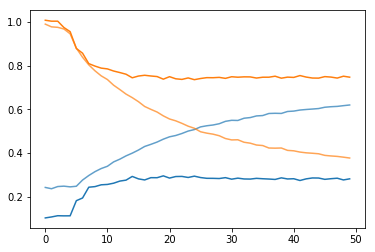

In [193]:
plt.plot(history.history['MOC'],'C0',alpha=0.7)
plt.plot(history.history['val_MOC'],'C0')
plt.plot(history.history['loss'],'C1',alpha=0.7)
plt.plot(history.history['val_loss'],'C1')

In [201]:
datadir = "/mnt/data/synthetic/syndat/"

In [195]:
X,Y = readdata(nframes,n=900,magn=4,repeat = 4)
historys = {}

In [203]:

for i in range(2,150):
    #ytr = np.abs(0.05*np.random.randn(Y.shape[0],Y.shape[1],Y.shape[2]))
    #Y1 = Y +ytr
    prGen = subprocess.Popen('./generatemore.sh')
    historys[i] = model.fit(X,Y, batch_size = 100, epochs = 10,
                           validation_data = (Xdev,Ydev),verbose=1)
    model.save("/mnt/data/synthetic/deepsofi_v2_t_"+str(i//10).zfill(4)+".h5")
    print(i)
    prGen.wait()
    X,Y = readdata(nframes,n=900,magn=4,repeat = 4)


Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 410us/step - loss: 0.6691 - MOC: 0.3570 - val_loss: 0.6554 - val_MOC: 0.3756
Epoch 2/10
3600/3600 [==============================] - 1s 392us/step - loss: 0.5933 - MOC: 0.4327 - val_loss: 0.6411 - val_MOC: 0.3872
Epoch 3/10
3600/3600 [==============================] - 1s 389us/step - loss: 0.5595 - MOC: 0.4651 - val_loss: 0.6334 - val_MOC: 0.3963
Epoch 4/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.5337 - MOC: 0.4896 - val_loss: 0.6298 - val_MOC: 0.3999
Epoch 5/10
3600/3600 [==============================] - 1s 388us/step - loss: 0.5155 - MOC: 0.5067 - val_loss: 0.6338 - val_MOC: 0.3947
Epoch 6/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.4972 - MOC: 0.5238 - val_loss: 0.6340 - val_MOC: 0.3941
Epoch 7/10
3600/3600 [==============================] - 1s 390us/step - loss: 0.4824 - MOC: 0.5376 - val_loss: 0.6364 - val_MOC: 0.3931
E

3600/3600 [==============================] - 1s 383us/step - loss: 0.4273 - MOC: 0.5911 - val_loss: 0.6019 - val_MOC: 0.4263
Epoch 10/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4156 - MOC: 0.6021 - val_loss: 0.6006 - val_MOC: 0.4274
7
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 401us/step - loss: 0.5939 - MOC: 0.4362 - val_loss: 0.5782 - val_MOC: 0.4526
Epoch 2/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.5440 - MOC: 0.4842 - val_loss: 0.5757 - val_MOC: 0.4535
Epoch 3/10
3600/3600 [==============================] - 1s 405us/step - loss: 0.5185 - MOC: 0.5085 - val_loss: 0.5694 - val_MOC: 0.4609
Epoch 4/10
3600/3600 [==============================] - 1s 406us/step - loss: 0.4992 - MOC: 0.5265 - val_loss: 0.5671 - val_MOC: 0.4634
Epoch 5/10
3600/3600 [==============================] - 1s 379us/step - loss: 0.4820 - MOC: 0.5424 - val_loss: 0.5696 - val_MOC: 0.4601
Epoch 6/1

3600/3600 [==============================] - 1s 380us/step - loss: 0.4474 - MOC: 0.5750 - val_loss: 0.5592 - val_MOC: 0.4675
Epoch 8/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4379 - MOC: 0.5834 - val_loss: 0.5678 - val_MOC: 0.4588
Epoch 9/10
3600/3600 [==============================] - 1s 378us/step - loss: 0.4242 - MOC: 0.5962 - val_loss: 0.5662 - val_MOC: 0.4616
Epoch 10/10
3600/3600 [==============================] - 1s 376us/step - loss: 0.4168 - MOC: 0.6030 - val_loss: 0.5660 - val_MOC: 0.4611
13
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 2s 436us/step - loss: 0.5708 - MOC: 0.4577 - val_loss: 0.5573 - val_MOC: 0.4715
Epoch 2/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.5262 - MOC: 0.5006 - val_loss: 0.5479 - val_MOC: 0.4828
Epoch 3/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.5013 - MOC: 0.5241 - val_loss: 0.5508 - val_MOC: 0.4799
Epoch 4/

3600/3600 [==============================] - 1s 385us/step - loss: 0.4605 - MOC: 0.5619 - val_loss: 0.5508 - val_MOC: 0.4776
Epoch 6/10
3600/3600 [==============================] - 1s 399us/step - loss: 0.4435 - MOC: 0.5775 - val_loss: 0.5520 - val_MOC: 0.4762
Epoch 7/10
3600/3600 [==============================] - 2s 428us/step - loss: 0.4290 - MOC: 0.5909 - val_loss: 0.5540 - val_MOC: 0.4730
Epoch 8/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4180 - MOC: 0.6010 - val_loss: 0.5577 - val_MOC: 0.4698
Epoch 9/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4074 - MOC: 0.6108 - val_loss: 0.5655 - val_MOC: 0.4625
Epoch 10/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.3998 - MOC: 0.6179 - val_loss: 0.5726 - val_MOC: 0.4535
19
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 411us/step - loss: 0.5631 - MOC: 0.4657 - val_loss: 0.5412 - val_MOC: 0.4905
Epoch 2/

3600/3600 [==============================] - 1s 389us/step - loss: 0.4915 - MOC: 0.5341 - val_loss: 0.5337 - val_MOC: 0.4947
Epoch 4/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.4744 - MOC: 0.5500 - val_loss: 0.5293 - val_MOC: 0.4992
Epoch 5/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4579 - MOC: 0.5652 - val_loss: 0.5324 - val_MOC: 0.4966
Epoch 6/10
3600/3600 [==============================] - 1s 390us/step - loss: 0.4437 - MOC: 0.5783 - val_loss: 0.5328 - val_MOC: 0.4942
Epoch 7/10
3600/3600 [==============================] - 2s 434us/step - loss: 0.4308 - MOC: 0.5903 - val_loss: 0.5378 - val_MOC: 0.4900
Epoch 8/10
3600/3600 [==============================] - 1s 389us/step - loss: 0.4191 - MOC: 0.6010 - val_loss: 0.5458 - val_MOC: 0.4815
Epoch 9/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4077 - MOC: 0.6113 - val_loss: 0.5545 - val_MOC: 0.4719
Epoch 10/10
3600/3600 [==============================] - 1s

3600/3600 [==============================] - 2s 446us/step - loss: 0.5512 - MOC: 0.4776 - val_loss: 0.5305 - val_MOC: 0.4984
Epoch 2/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.5138 - MOC: 0.5138 - val_loss: 0.5227 - val_MOC: 0.5066
Epoch 3/10
3600/3600 [==============================] - 1s 379us/step - loss: 0.4889 - MOC: 0.5371 - val_loss: 0.5283 - val_MOC: 0.5001
Epoch 4/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4723 - MOC: 0.5524 - val_loss: 0.5370 - val_MOC: 0.4902
Epoch 5/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4562 - MOC: 0.5673 - val_loss: 0.5304 - val_MOC: 0.4984
Epoch 6/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4444 - MOC: 0.5782 - val_loss: 0.5350 - val_MOC: 0.4934
Epoch 7/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4298 - MOC: 0.5915 - val_loss: 0.5382 - val_MOC: 0.4886
Epoch 8/10
3600/3600 [==============================] - 1s 

3600/3600 [==============================] - 1s 392us/step - loss: 0.4024 - MOC: 0.6165 - val_loss: 0.5397 - val_MOC: 0.4858
Epoch 10/10
3600/3600 [==============================] - 2s 435us/step - loss: 0.3908 - MOC: 0.6269 - val_loss: 0.5393 - val_MOC: 0.4879
36
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 407us/step - loss: 0.5382 - MOC: 0.4889 - val_loss: 0.5149 - val_MOC: 0.5128
Epoch 2/10
3600/3600 [==============================] - 1s 388us/step - loss: 0.4996 - MOC: 0.5264 - val_loss: 0.5214 - val_MOC: 0.5051
Epoch 3/10
3600/3600 [==============================] - 1s 388us/step - loss: 0.4761 - MOC: 0.5482 - val_loss: 0.5183 - val_MOC: 0.5083
Epoch 4/10
3600/3600 [==============================] - 1s 384us/step - loss: 0.4614 - MOC: 0.5619 - val_loss: 0.5122 - val_MOC: 0.5148
Epoch 5/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4450 - MOC: 0.5772 - val_loss: 0.5139 - val_MOC: 0.5132
Epoch 6/

3600/3600 [==============================] - 1s 382us/step - loss: 0.4188 - MOC: 0.6019 - val_loss: 0.5319 - val_MOC: 0.4941
Epoch 8/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4096 - MOC: 0.6103 - val_loss: 0.5242 - val_MOC: 0.5022
Epoch 9/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.3973 - MOC: 0.6217 - val_loss: 0.5272 - val_MOC: 0.4993
Epoch 10/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.3887 - MOC: 0.6295 - val_loss: 0.5300 - val_MOC: 0.4959
42
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 2s 436us/step - loss: 0.5338 - MOC: 0.4944 - val_loss: 0.5092 - val_MOC: 0.5204
Epoch 2/10
3600/3600 [==============================] - 1s 388us/step - loss: 0.4948 - MOC: 0.5320 - val_loss: 0.5019 - val_MOC: 0.5261
Epoch 3/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4745 - MOC: 0.5511 - val_loss: 0.5029 - val_MOC: 0.5252
Epoch 4/

3600/3600 [==============================] - 1s 384us/step - loss: 0.4406 - MOC: 0.5817 - val_loss: 0.5129 - val_MOC: 0.5145
Epoch 6/10
3600/3600 [==============================] - 1s 384us/step - loss: 0.4269 - MOC: 0.5945 - val_loss: 0.5119 - val_MOC: 0.5155
Epoch 7/10
3600/3600 [==============================] - 1s 390us/step - loss: 0.4195 - MOC: 0.6012 - val_loss: 0.5162 - val_MOC: 0.5105
Epoch 8/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.4054 - MOC: 0.6143 - val_loss: 0.5156 - val_MOC: 0.5114
Epoch 9/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.3979 - MOC: 0.6211 - val_loss: 0.5267 - val_MOC: 0.4997
Epoch 10/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.3887 - MOC: 0.6297 - val_loss: 0.5256 - val_MOC: 0.5009
48
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 2s 417us/step - loss: 0.5328 - MOC: 0.4949 - val_loss: 0.5121 - val_MOC: 0.5159
Epoch 2/

3600/3600 [==============================] - 1s 386us/step - loss: 0.4775 - MOC: 0.5472 - val_loss: 0.5015 - val_MOC: 0.5258
Epoch 4/10
3600/3600 [==============================] - 1s 389us/step - loss: 0.4636 - MOC: 0.5602 - val_loss: 0.5002 - val_MOC: 0.5264
Epoch 5/10
3600/3600 [==============================] - 1s 413us/step - loss: 0.4519 - MOC: 0.5710 - val_loss: 0.4985 - val_MOC: 0.5286
Epoch 6/10
3600/3600 [==============================] - 1s 393us/step - loss: 0.4370 - MOC: 0.5849 - val_loss: 0.5018 - val_MOC: 0.5245
Epoch 7/10
3600/3600 [==============================] - 1s 394us/step - loss: 0.4250 - MOC: 0.5958 - val_loss: 0.5018 - val_MOC: 0.5248
Epoch 8/10
3600/3600 [==============================] - 2s 437us/step - loss: 0.4171 - MOC: 0.6033 - val_loss: 0.5090 - val_MOC: 0.5169
Epoch 9/10
3600/3600 [==============================] - 1s 400us/step - loss: 0.4075 - MOC: 0.6120 - val_loss: 0.5116 - val_MOC: 0.5142
Epoch 10/10
3600/3600 [==============================] - 1s

3600/3600 [==============================] - 1s 395us/step - loss: 0.5324 - MOC: 0.4947 - val_loss: 0.4973 - val_MOC: 0.5305
Epoch 2/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.4984 - MOC: 0.5275 - val_loss: 0.4886 - val_MOC: 0.5395
Epoch 3/10
3600/3600 [==============================] - 2s 450us/step - loss: 0.4763 - MOC: 0.5482 - val_loss: 0.4913 - val_MOC: 0.5354
Epoch 4/10
3600/3600 [==============================] - 1s 416us/step - loss: 0.4623 - MOC: 0.5611 - val_loss: 0.4948 - val_MOC: 0.5314
Epoch 5/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4491 - MOC: 0.5732 - val_loss: 0.4935 - val_MOC: 0.5331
Epoch 6/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4368 - MOC: 0.5846 - val_loss: 0.5033 - val_MOC: 0.5221
Epoch 7/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4233 - MOC: 0.5971 - val_loss: 0.5036 - val_MOC: 0.5220
Epoch 8/10
3600/3600 [==============================] - 1s 

3600/3600 [==============================] - 1s 388us/step - loss: 0.3988 - MOC: 0.6205 - val_loss: 0.5039 - val_MOC: 0.5215
Epoch 10/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.3911 - MOC: 0.6276 - val_loss: 0.5066 - val_MOC: 0.5188
65
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 2s 418us/step - loss: 0.5268 - MOC: 0.5014 - val_loss: 0.5095 - val_MOC: 0.5172
Epoch 2/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.4978 - MOC: 0.5296 - val_loss: 0.4970 - val_MOC: 0.5299
Epoch 3/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4754 - MOC: 0.5504 - val_loss: 0.4991 - val_MOC: 0.5274
Epoch 4/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4627 - MOC: 0.5622 - val_loss: 0.4982 - val_MOC: 0.5297
Epoch 5/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4512 - MOC: 0.5728 - val_loss: 0.5070 - val_MOC: 0.5193
Epoch 6/

3600/3600 [==============================] - 1s 386us/step - loss: 0.4254 - MOC: 0.5966 - val_loss: 0.4970 - val_MOC: 0.5289
Epoch 8/10
3600/3600 [==============================] - 1s 384us/step - loss: 0.4164 - MOC: 0.6048 - val_loss: 0.5085 - val_MOC: 0.5174
Epoch 9/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4081 - MOC: 0.6124 - val_loss: 0.5029 - val_MOC: 0.5234
Epoch 10/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.3989 - MOC: 0.6210 - val_loss: 0.5062 - val_MOC: 0.5196
71
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 400us/step - loss: 0.5167 - MOC: 0.5095 - val_loss: 0.4908 - val_MOC: 0.5372
Epoch 2/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4892 - MOC: 0.5361 - val_loss: 0.4944 - val_MOC: 0.5329
Epoch 3/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.4688 - MOC: 0.5553 - val_loss: 0.4935 - val_MOC: 0.5341
Epoch 4/

3600/3600 [==============================] - 1s 380us/step - loss: 0.4495 - MOC: 0.5744 - val_loss: 0.5015 - val_MOC: 0.5248
Epoch 6/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4390 - MOC: 0.5842 - val_loss: 0.4987 - val_MOC: 0.5292
Epoch 7/10
3600/3600 [==============================] - 1s 379us/step - loss: 0.4304 - MOC: 0.5922 - val_loss: 0.5008 - val_MOC: 0.5263
Epoch 8/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4217 - MOC: 0.6001 - val_loss: 0.5044 - val_MOC: 0.5221
Epoch 9/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4102 - MOC: 0.6107 - val_loss: 0.5082 - val_MOC: 0.5185
Epoch 10/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4026 - MOC: 0.6177 - val_loss: 0.5185 - val_MOC: 0.5079
77
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 2s 455us/step - loss: 0.5097 - MOC: 0.5160 - val_loss: 0.5062 - val_MOC: 0.5218
Epoch 2/

3600/3600 [==============================] - 1s 383us/step - loss: 0.4724 - MOC: 0.5533 - val_loss: 0.4842 - val_MOC: 0.5425
Epoch 4/10
3600/3600 [==============================] - 1s 384us/step - loss: 0.4570 - MOC: 0.5675 - val_loss: 0.4871 - val_MOC: 0.5394
Epoch 5/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4468 - MOC: 0.5768 - val_loss: 0.4866 - val_MOC: 0.5393
Epoch 6/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4343 - MOC: 0.5884 - val_loss: 0.4879 - val_MOC: 0.5385
Epoch 7/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4254 - MOC: 0.5965 - val_loss: 0.5026 - val_MOC: 0.5221
Epoch 8/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.4163 - MOC: 0.6050 - val_loss: 0.4891 - val_MOC: 0.5365
Epoch 9/10
3600/3600 [==============================] - 2s 429us/step - loss: 0.4064 - MOC: 0.6142 - val_loss: 0.5000 - val_MOC: 0.5253
Epoch 10/10
3600/3600 [==============================] - 1s

3600/3600 [==============================] - 2s 455us/step - loss: 0.5173 - MOC: 0.5103 - val_loss: 0.4874 - val_MOC: 0.5392
Epoch 2/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.4897 - MOC: 0.5371 - val_loss: 0.4833 - val_MOC: 0.5426
Epoch 3/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4721 - MOC: 0.5536 - val_loss: 0.4827 - val_MOC: 0.5431
Epoch 4/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4595 - MOC: 0.5651 - val_loss: 0.4804 - val_MOC: 0.5452
Epoch 5/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4485 - MOC: 0.5754 - val_loss: 0.4841 - val_MOC: 0.5407
Epoch 6/10
3600/3600 [==============================] - 1s 384us/step - loss: 0.4365 - MOC: 0.5864 - val_loss: 0.4877 - val_MOC: 0.5369
Epoch 7/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4272 - MOC: 0.5952 - val_loss: 0.4916 - val_MOC: 0.5333
Epoch 8/10
3600/3600 [==============================] - 1s 

3600/3600 [==============================] - 1s 382us/step - loss: 0.4143 - MOC: 0.6074 - val_loss: 0.4993 - val_MOC: 0.5265
Epoch 10/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4090 - MOC: 0.6122 - val_loss: 0.5052 - val_MOC: 0.5205
94
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 399us/step - loss: 0.5157 - MOC: 0.5103 - val_loss: 0.4906 - val_MOC: 0.5362
Epoch 2/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4845 - MOC: 0.5405 - val_loss: 0.4853 - val_MOC: 0.5414
Epoch 3/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.4660 - MOC: 0.5579 - val_loss: 0.4845 - val_MOC: 0.5419
Epoch 4/10
3600/3600 [==============================] - 2s 428us/step - loss: 0.4544 - MOC: 0.5687 - val_loss: 0.4839 - val_MOC: 0.5427
Epoch 5/10
3600/3600 [==============================] - 1s 398us/step - loss: 0.4417 - MOC: 0.5805 - val_loss: 0.4884 - val_MOC: 0.5369
Epoch 6/

3600/3600 [==============================] - 1s 382us/step - loss: 0.4232 - MOC: 0.5974 - val_loss: 0.4983 - val_MOC: 0.5276
Epoch 8/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4121 - MOC: 0.6078 - val_loss: 0.5039 - val_MOC: 0.5214
Epoch 9/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4029 - MOC: 0.6163 - val_loss: 0.5027 - val_MOC: 0.5222
Epoch 10/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4001 - MOC: 0.6187 - val_loss: 0.5135 - val_MOC: 0.5121
100
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 2s 449us/step - loss: 0.5181 - MOC: 0.5087 - val_loss: 0.4948 - val_MOC: 0.5318
Epoch 2/10
3600/3600 [==============================] - 1s 391us/step - loss: 0.4897 - MOC: 0.5364 - val_loss: 0.4905 - val_MOC: 0.5360
Epoch 3/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.4708 - MOC: 0.5542 - val_loss: 0.4866 - val_MOC: 0.5401
Epoch 4

3600/3600 [==============================] - 1s 383us/step - loss: 0.4431 - MOC: 0.5791 - val_loss: 0.4890 - val_MOC: 0.5359
Epoch 6/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4329 - MOC: 0.5885 - val_loss: 0.4859 - val_MOC: 0.5398
Epoch 7/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4239 - MOC: 0.5969 - val_loss: 0.4976 - val_MOC: 0.5276
Epoch 8/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4175 - MOC: 0.6027 - val_loss: 0.4922 - val_MOC: 0.5338
Epoch 9/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4071 - MOC: 0.6123 - val_loss: 0.4961 - val_MOC: 0.5291
Epoch 10/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.3988 - MOC: 0.6201 - val_loss: 0.4923 - val_MOC: 0.5347
106
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 2s 419us/step - loss: 0.5082 - MOC: 0.5180 - val_loss: 0.4942 - val_MOC: 0.5325
Epoch 2

3600/3600 [==============================] - 1s 382us/step - loss: 0.4689 - MOC: 0.5562 - val_loss: 0.4710 - val_MOC: 0.5558
Epoch 4/10
3600/3600 [==============================] - 2s 448us/step - loss: 0.4596 - MOC: 0.5650 - val_loss: 0.4730 - val_MOC: 0.5533
Epoch 5/10
3600/3600 [==============================] - 1s 409us/step - loss: 0.4478 - MOC: 0.5758 - val_loss: 0.4810 - val_MOC: 0.5441
Epoch 6/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4369 - MOC: 0.5857 - val_loss: 0.4818 - val_MOC: 0.5444
Epoch 7/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4289 - MOC: 0.5932 - val_loss: 0.4805 - val_MOC: 0.5452
Epoch 8/10
3600/3600 [==============================] - 1s 379us/step - loss: 0.4222 - MOC: 0.5994 - val_loss: 0.4839 - val_MOC: 0.5410
Epoch 9/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4113 - MOC: 0.6093 - val_loss: 0.4832 - val_MOC: 0.5414
Epoch 10/10
3600/3600 [==============================] - 1s

3600/3600 [==============================] - 1s 399us/step - loss: 0.5062 - MOC: 0.5205 - val_loss: 0.4828 - val_MOC: 0.5443
Epoch 2/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4818 - MOC: 0.5440 - val_loss: 0.4813 - val_MOC: 0.5451
Epoch 3/10
3600/3600 [==============================] - 1s 387us/step - loss: 0.4658 - MOC: 0.5591 - val_loss: 0.4891 - val_MOC: 0.5367
Epoch 4/10
3600/3600 [==============================] - 1s 415us/step - loss: 0.4547 - MOC: 0.5694 - val_loss: 0.4843 - val_MOC: 0.5419
Epoch 5/10
3600/3600 [==============================] - 2s 443us/step - loss: 0.4443 - MOC: 0.5789 - val_loss: 0.4829 - val_MOC: 0.5434
Epoch 6/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4342 - MOC: 0.5884 - val_loss: 0.4910 - val_MOC: 0.5342
Epoch 7/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4244 - MOC: 0.5973 - val_loss: 0.4871 - val_MOC: 0.5392
Epoch 8/10
3600/3600 [==============================] - 1s 

3600/3600 [==============================] - 2s 434us/step - loss: 0.4077 - MOC: 0.6129 - val_loss: 0.4862 - val_MOC: 0.5397
Epoch 10/10
3600/3600 [==============================] - 1s 396us/step - loss: 0.3997 - MOC: 0.6202 - val_loss: 0.4861 - val_MOC: 0.5393
123
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 405us/step - loss: 0.5096 - MOC: 0.5161 - val_loss: 0.4767 - val_MOC: 0.5508
Epoch 2/10
3600/3600 [==============================] - 1s 391us/step - loss: 0.4857 - MOC: 0.5394 - val_loss: 0.4810 - val_MOC: 0.5452
Epoch 3/10
3600/3600 [==============================] - 1s 397us/step - loss: 0.4706 - MOC: 0.5535 - val_loss: 0.4765 - val_MOC: 0.5492
Epoch 4/10
3600/3600 [==============================] - 1s 390us/step - loss: 0.4609 - MOC: 0.5624 - val_loss: 0.4761 - val_MOC: 0.5502
Epoch 5/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4485 - MOC: 0.5740 - val_loss: 0.4787 - val_MOC: 0.5473
Epoch 6

3600/3600 [==============================] - 1s 402us/step - loss: 0.4297 - MOC: 0.5918 - val_loss: 0.4843 - val_MOC: 0.5413
Epoch 8/10
3600/3600 [==============================] - 1s 386us/step - loss: 0.4231 - MOC: 0.5979 - val_loss: 0.4792 - val_MOC: 0.5461
Epoch 9/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4130 - MOC: 0.6073 - val_loss: 0.4852 - val_MOC: 0.5396
Epoch 10/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4056 - MOC: 0.6141 - val_loss: 0.4883 - val_MOC: 0.5370
129
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 395us/step - loss: 0.5107 - MOC: 0.5168 - val_loss: 0.4781 - val_MOC: 0.5482
Epoch 2/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4862 - MOC: 0.5406 - val_loss: 0.4865 - val_MOC: 0.5389
Epoch 3/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4721 - MOC: 0.5537 - val_loss: 0.4764 - val_MOC: 0.5505
Epoch 4

3600/3600 [==============================] - 1s 390us/step - loss: 0.4430 - MOC: 0.5798 - val_loss: 0.4911 - val_MOC: 0.5341
Epoch 6/10
3600/3600 [==============================] - 1s 414us/step - loss: 0.4334 - MOC: 0.5885 - val_loss: 0.4936 - val_MOC: 0.5320
Epoch 7/10
3600/3600 [==============================] - 1s 395us/step - loss: 0.4262 - MOC: 0.5952 - val_loss: 0.4933 - val_MOC: 0.5316
Epoch 8/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4200 - MOC: 0.6009 - val_loss: 0.4951 - val_MOC: 0.5302
Epoch 9/10
3600/3600 [==============================] - 1s 380us/step - loss: 0.4109 - MOC: 0.6092 - val_loss: 0.4918 - val_MOC: 0.5340
Epoch 10/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4041 - MOC: 0.6156 - val_loss: 0.4952 - val_MOC: 0.5301
135
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 1s 405us/step - loss: 0.5044 - MOC: 0.5220 - val_loss: 0.4799 - val_MOC: 0.5480
Epoch 2

3600/3600 [==============================] - 1s 384us/step - loss: 0.4660 - MOC: 0.5583 - val_loss: 0.4801 - val_MOC: 0.5459
Epoch 4/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4541 - MOC: 0.5693 - val_loss: 0.4797 - val_MOC: 0.5464
Epoch 5/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4436 - MOC: 0.5790 - val_loss: 0.4840 - val_MOC: 0.5410
Epoch 6/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4360 - MOC: 0.5859 - val_loss: 0.4804 - val_MOC: 0.5450
Epoch 7/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4274 - MOC: 0.5939 - val_loss: 0.4801 - val_MOC: 0.5454
Epoch 8/10
3600/3600 [==============================] - 1s 384us/step - loss: 0.4210 - MOC: 0.5999 - val_loss: 0.4820 - val_MOC: 0.5439
Epoch 9/10
3600/3600 [==============================] - 2s 419us/step - loss: 0.4128 - MOC: 0.6074 - val_loss: 0.4862 - val_MOC: 0.5395
Epoch 10/10
3600/3600 [==============================] - 1s

3600/3600 [==============================] - 1s 402us/step - loss: 0.5035 - MOC: 0.5225 - val_loss: 0.4847 - val_MOC: 0.5419
Epoch 2/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4802 - MOC: 0.5453 - val_loss: 0.4798 - val_MOC: 0.5464
Epoch 3/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4670 - MOC: 0.5576 - val_loss: 0.4760 - val_MOC: 0.5500
Epoch 4/10
3600/3600 [==============================] - 1s 385us/step - loss: 0.4562 - MOC: 0.5676 - val_loss: 0.4756 - val_MOC: 0.5509
Epoch 5/10
3600/3600 [==============================] - 1s 382us/step - loss: 0.4473 - MOC: 0.5758 - val_loss: 0.4779 - val_MOC: 0.5479
Epoch 6/10
3600/3600 [==============================] - 1s 381us/step - loss: 0.4370 - MOC: 0.5854 - val_loss: 0.4688 - val_MOC: 0.5576
Epoch 7/10
3600/3600 [==============================] - 1s 383us/step - loss: 0.4287 - MOC: 0.5930 - val_loss: 0.4768 - val_MOC: 0.5481
Epoch 8/10
3600/3600 [==============================] - 1s 

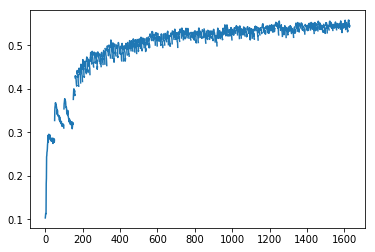

In [216]:
i0 = len(history.history['val_MOC'])
plt.plot(history.history['val_MOC'])
for i in range(150):
    vMOC = historys[i].history['val_MOC']
    t = np.arange(len(vMOC))+i0
    plt.plot(t,vMOC,'C0')
    i0 = t[-1]+1

In [160]:
import subprocess

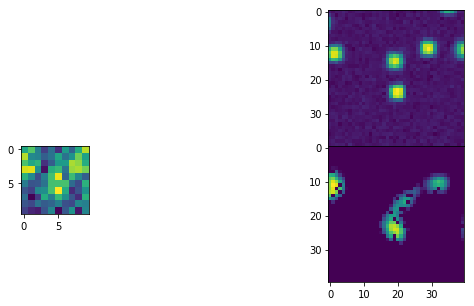

In [225]:
i = randint(100)
Ft, Ot4 = Xdev[i,:],Ydev[i,:]
pOt4 = model.predict(Ft.reshape(1,Ft.shape[0],Ft.shape[1],Ft.shape[2],1))
fig = plt.figure(figsize=(14,5))
gs = mpl.gridspec.GridSpec(8, 16 , wspace=0., hspace=0.) # 2x3 grid
Ft = np.squeeze(Ft)
pOt4 = np.squeeze(pOt4)

ax0 = fig.add_subplot(gs[4:6,4:6]) # first full col
ax1 = fig.add_subplot(gs[:4,8:]) # first row, second col
ax2 = fig.add_subplot(gs[4:,8:])
ax0.imshow(Ft.mean(axis=-1))
ax1.imshow(Ot4+np.random.randn(40,40)*.02)
ax2.imshow(pOt4)

In [29]:
pOt4.shape

(1, 40, 40)